In [1]:
import findspark
findspark.init('/usr/spark2.4.3')

In [2]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix



In [3]:
# Read data from the vehicle_stolen_datḤaset.csv 
loan_data = pd.read_csv("loan2000.csv",low_memory=False) 
#Sets the Spark master URL to run locally. 
spark = SparkSession.builder.master("local[*]").getOrCreate() 

#print("There are",loan_data.count(),"rows",len(loan_data.columns),
#      "columns" ,"in the data.")

loan_data.info()                                                              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359985 entries, 0 to 359984
Data columns (total 17 columns):
emp_length_int          359985 non-null float64
home_ownership_cat      359985 non-null int64
annual_inc              359985 non-null int64
income_cat              359985 non-null int64
loan_amount             359985 non-null int64
term_cat                359985 non-null int64
application_type_cat    359985 non-null int64
purpose_cat             359985 non-null int64
interest_payment_cat    359985 non-null int64
loan_condition_cat      359985 non-null int64
interest_rate           359985 non-null float64
grade_cat               359985 non-null int64
dti                     359985 non-null float64
total_pymnt             359985 non-null float64
total_rec_prncp         359985 non-null float64
recoveries              359985 non-null float64
installment             359985 non-null float64
dtypes: float64(7), int64(10)
memory usage: 46.7 MB


In [4]:
#Create DataFrame 
df = spark.createDataFrame(loan_data) 
df.show(5)

+--------------+------------------+----------+----------+-----------+--------+--------------------+-----------+--------------------+------------------+-------------+---------+-----+-----------+---------------+----------+-----------+
|emp_length_int|home_ownership_cat|annual_inc|income_cat|loan_amount|term_cat|application_type_cat|purpose_cat|interest_payment_cat|loan_condition_cat|interest_rate|grade_cat|  dti|total_pymnt|total_rec_prncp|recoveries|installment|
+--------------+------------------+----------+----------+-----------+--------+--------------------+-----------+--------------------+------------------+-------------+---------+-----+-----------+---------------+----------+-----------+
|          10.0|                 1|     24000|         1|       5000|       1|                   1|          1|                   1|                 0|        10.65|        2|27.65|5861.071414|         5000.0|       0.0|     162.87|
|           0.5|                 1|     30000|         1|       2500

In [5]:
df.printSchema()

root
 |-- emp_length_int: double (nullable = true)
 |-- home_ownership_cat: long (nullable = true)
 |-- annual_inc: long (nullable = true)
 |-- income_cat: long (nullable = true)
 |-- loan_amount: long (nullable = true)
 |-- term_cat: long (nullable = true)
 |-- application_type_cat: long (nullable = true)
 |-- purpose_cat: long (nullable = true)
 |-- interest_payment_cat: long (nullable = true)
 |-- loan_condition_cat: long (nullable = true)
 |-- interest_rate: double (nullable = true)
 |-- grade_cat: long (nullable = true)
 |-- dti: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- installment: double (nullable = true)



In [6]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max


In [7]:
df.groupby("loan_condition_cat").count().show()

+------------------+------+
|loan_condition_cat| count|
+------------------+------+
|                 0|316145|
|                 1| 43840|
+------------------+------+



In [8]:
#check for null values if any

from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,emp_length_int,home_ownership_cat,annual_inc,income_cat,loan_amount,term_cat,application_type_cat,purpose_cat,interest_payment_cat,loan_condition_cat,interest_rate,grade_cat,dti,total_pymnt,total_rec_prncp,recoveries,installment
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df=df.select(numeric_features)
col_names =numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,emp_length_int,home_ownership_cat,annual_inc,income_cat,loan_amount,term_cat,application_type_cat,purpose_cat,interest_payment_cat,loan_condition_cat,interest_rate,grade_cat,dti,total_pymnt,total_rec_prncp,recoveries,installment
emp_length_int,1.000000,0.213251,0.076223,0.039906,0.122568,0.081425,0.001316,0.006490,0.018633,-0.013167,0.024720,0.011910,0.056417,0.080666,0.060731,0.008370,0.106607
home_ownership_cat,0.213251,1.000000,0.185814,0.161922,0.203385,0.118353,-0.001124,0.018268,-0.064503,-0.043655,-0.075746,-0.072963,0.004300,0.151020,0.138081,0.005813,0.167778
annual_inc,0.076223,0.185814,1.000000,0.696542,0.362636,0.070792,-0.002434,0.013164,-0.045976,-0.047611,-0.042833,-0.033398,-0.184494,0.289601,0.270290,0.018405,0.358701
income_cat,0.039906,0.161922,0.696542,1.000000,0.335393,0.043934,-0.002274,0.009658,-0.045203,-0.044598,-0.045981,-0.035140,-0.184894,0.269511,0.254097,0.014113,0.335350
loan_amount,0.122568,0.203385,0.362636,0.335393,1.000000,0.418287,-0.001080,-0.025099,0.124952,0.018842,0.177772,0.172993,0.062111,0.738089,0.617067,0.115019,0.948679
term_cat,0.081425,0.118353,0.070792,0.043934,0.418287,1.000000,-0.000294,0.035645,0.343407,0.070249,0.427937,0.438498,0.093518,0.183849,0.022456,0.092360,0.164697
application_type_cat,0.001316,-0.001124,-0.002434,-0.002274,-0.001080,-0.000294,1.000000,-0.000131,-0.002490,0.000643,-0.002615,-0.002196,-0.001306,0.000461,0.001236,-0.000912,-0.002021
purpose_cat,0.006490,0.018268,0.013164,0.009658,-0.025099,0.035645,-0.000131,1.000000,0.087573,0.027956,0.100506,0.106752,-0.024874,-0.007256,-0.016070,0.014107,-0.028109
interest_payment_cat,0.018633,-0.064503,-0.045976,-0.045203,0.124952,0.343407,-0.002490,0.087573,1.000000,0.146525,0.799288,0.770098,0.147799,0.093354,-0.026693,0.091435,0.112640
loan_condition_cat,-0.013167,-0.043655,-0.047611,-0.044598,0.018842,0.070249,0.000643,0.027956,0.146525,1.000000,0.183677,0.176476,0.051989,-0.188472,-0.256496,0.420285,0.021182


In [10]:
df2=df
df3=df

In [11]:
categoricalColumns = [
 'home_ownership_cat',
 'income_cat',
 'term_cat',
 'application_type_cat',
 'purpose_cat',
 'interest_payment_cat',
 'grade_cat'
]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'loan_condition_cat', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ["emp_length_int", 'annual_inc', 'loan_amount', 'interest_rate','dti','total_pymnt','total_rec_prncp',
               'recoveries','installment']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features")
stages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

In [12]:
cols = df.columns
cols

['emp_length_int',
 'home_ownership_cat',
 'annual_inc',
 'income_cat',
 'loan_amount',
 'term_cat',
 'application_type_cat',
 'purpose_cat',
 'interest_payment_cat',
 'loan_condition_cat',
 'interest_rate',
 'grade_cat',
 'dti',
 'total_pymnt',
 'total_rec_prncp',
 'recoveries',
 'installment']

In [13]:
stages

[StringIndexer_66a152483742,
 OneHotEncoderEstimator_6bfe7adef479,
 StringIndexer_cf36987f8fec,
 OneHotEncoderEstimator_f50115a19da3,
 StringIndexer_84ea899fb5b3,
 OneHotEncoderEstimator_0f552a55218f,
 StringIndexer_7ad8cd07b03b,
 OneHotEncoderEstimator_af4bd8d0811d,
 StringIndexer_97af0858132d,
 OneHotEncoderEstimator_c8f24080d74f,
 StringIndexer_82a344d7a468,
 OneHotEncoderEstimator_c7c262349660,
 StringIndexer_f609bbaac27d,
 OneHotEncoderEstimator_19a9f1d8e605,
 StringIndexer_5671671c4443,
 VectorAssembler_31a10b893c37,
 StandardScaler_85e693fc34fc]

In [14]:
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- emp_length_int: double (nullable = true)
 |-- home_ownership_cat: long (nullable = true)
 |-- annual_inc: long (nullable = true)
 |-- income_cat: long (nullable = true)
 |-- loan_amount: long (nullable = true)
 |-- term_cat: long (nullable = true)
 |-- application_type_cat: long (nullable = true)
 |-- purpose_cat: long (nullable = true)
 |-- interest_payment_cat: long (nullable = true)
 |-- loan_condition_cat: long (nullable = true)
 |-- interest_rate: double (nullable = true)
 |-- grade_cat: long (nullable = true)
 |-- dti: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- installment: double (nullable = true)



In [15]:
train, test = df.randomSplit([0.8, 0.2], seed = 2023)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 288288
Test Dataset Count: 71697


In [16]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions_train = lrModel.transform(train)
#predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

In [22]:
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(5)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.0000106881665136, 0.0, 0.0, 0.0, 0.0, 2.706...","[2.4877569255368264, -2.4877569255368264]",0.0,"[0.9232790656229303, 0.07672093437706975]"
1,0.0,"(2.0000106881665136, 0.0, 0.0, 0.0, 0.0, 2.706...","[3.1751160916322534, -3.1751160916322534]",0.0,"[0.9598870382626068, 0.04011296173739326]"
2,0.0,"(2.0000106881665136, 0.0, 0.0, 0.0, 0.0, 2.706...","[2.4405881040437043, -2.4405881040437043]",0.0,"[0.9198704469804013, 0.08012955301959854]"
3,0.0,"(2.0000106881665136, 0.0, 0.0, 0.0, 0.0, 2.706...","[2.9146884027765934, -2.9146884027765934]",0.0,"[0.9485677790280281, 0.051432220971971844]"
4,0.0,"(2.0000106881665136, 0.0, 0.0, 0.0, 0.0, 2.706...","[3.579747554356233, -3.579747554356233]",0.0,"[0.9728736214170769, 0.027126378582923195]"


In [17]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 2164  6502]
 [  384 62647]]


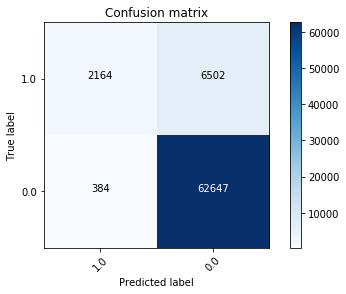

In [18]:
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [19]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9039569298575951


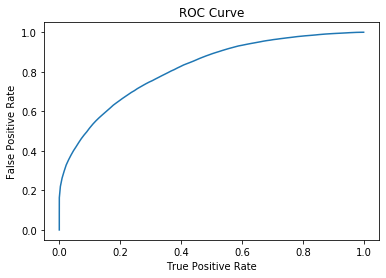

Training set areaUnderROC: 0.8161702615863812


In [20]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8235242665184784
